In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # Enable the experimental module
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

C:\Users\Aman\anaconda3\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
data = pd.read_csv('train_data.csv')

In [3]:
data['timestamp'] = pd.to_datetime(data["timestamp"])

In [4]:
data=data.sort_values(['timestamp'],ascending=[True])

In [5]:
for i in range(2):
    data['Period Code1'] = np.where(data['timestamp'].dt.date == data['timestamp'].dt.date.shift(1), data['Period Code'].shift(1), data['Period Code'])
    data['Period Code'] = np.where(data['Period Code1'].str.isdigit(), data['Period Code1'], data['Period Code'])

In [6]:
data['Period Code1'] = np.where(data['timestamp'].dt.date == data['timestamp'].dt.date.shift(-1), data['Period Code'].shift(-1), data['Period Code'])

In [7]:
data['Period Code'] = np.where(data['Period Code1'].str.isdigit(), data['Period Code1'], data['Period Code'])

In [8]:
data['Period Code'] = data['Period Code'].fillna(method='ffill')
data['Period Code'] = data['Period Code'].astype(int)

In [9]:
data.drop(columns=['Period Code1', 'B_4','B_5','B_9','B_10','B_14', 'B_20', 'B_22', 'B_23'], axis=1, inplace=True)

In [10]:
data['Cycle ID'] = np.where(data['Cycle ID'].str.isdigit(), data['Cycle ID'], None)

In [11]:
data['Cycle ID'] = pd.to_numeric(data['Cycle ID'], errors='coerce')
data['Cycle ID'] = data['Cycle ID'].ffill().add(data['Cycle ID'].isna().cumsum())

In [12]:
def fillna_with_group_mean(df, group_column, value_column):
    df[value_column] = pd.to_numeric(df[value_column], errors='coerce')    
    df[value_column] = df.groupby(group_column)[value_column].transform(lambda x: x.fillna(x.mean()))
    return df

In [13]:
populate_column = ['B_2',	'B_3',	'B_15',	'B_16',	'B_17',	'B_18',	'B_19','B_21','B_24','B_25']

In [14]:
for name in populate_column:
    data = fillna_with_group_mean(data, 'Period Code', name)

In [15]:
data['ID'] = data['timestamp'].astype(str) + '-' +data['Cycle ID'].astype(str)

In [16]:
data.dropna(subset=['Good/Bad'],inplace=True)

In [17]:
test_data = pd.read_csv('test_data.csv')

In [18]:
test_data['B_2'] = pd.to_numeric(test_data['B_2'], errors='coerce')
test_data['B_3'] = pd.to_numeric(test_data['B_3'], errors='coerce')
test_data['B_15'] = pd.to_numeric(test_data['B_15'], errors='coerce')
test_data['B_16'] = pd.to_numeric(test_data['B_16'], errors='coerce')
test_data['B_17'] = pd.to_numeric(test_data['B_17'], errors='coerce')
test_data['B_18'] = pd.to_numeric(test_data['B_18'], errors='coerce')
test_data['B_19'] = pd.to_numeric(test_data['B_19'], errors='coerce')
test_data['B_21'] = pd.to_numeric(test_data['B_21'], errors='coerce')
test_data['B_24'] = pd.to_numeric(test_data['B_24'], errors='coerce')
test_data['B_25'] = pd.to_numeric(test_data['B_24'], errors='coerce')

In [19]:
X = data[['B_2',	'B_3',	'B_15',	'B_16',	'B_17',	'B_18',	'B_19',	'B_21',	'B_24',	'B_25']]
y = data['Good/Bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_classifier = HistGradientBoostingClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the accuracy and classification report
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)

Accuracy: 0.9589379438098179
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2741
           1       0.88      0.85      0.86       498

    accuracy                           0.96      3239
   macro avg       0.93      0.91      0.92      3239
weighted avg       0.96      0.96      0.96      3239



In [24]:
X_test=test_data[['B_2','B_3',	'B_15',	'B_16',	'B_17',	'B_18',	'B_19',	'B_21',	'B_24',	'B_25']]
y_pred = rf_classifier.predict(X_test)

In [25]:
X_test['Good/Bad'] = y_pred

C:\Users\Aman\AppData\Local\Temp/ipykernel_11796/1384814958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Good/Bad'] = y_pred


In [26]:
test_data['ID'] = test_data['timestamp'].astype(str) + '-' +test_data['Cycle ID'].astype(str)

In [27]:
test_data = pd.merge(test_data[['timestamp',	'ID', 'Period Code',	'Cycle ID']], X_test, left_index=True, right_index=True)

In [28]:
test_data = test_data[['ID', 'Good/Bad']]

In [29]:
test_data.to_csv('result.csv',index=False)

In [30]:
test_data

,ID,Good/Bad
0,4/27/2020 7:20-127,0
1,4/27/2020 7:25-128,0
2,4/27/2020 7:30-129,0
3,4/27/2020 7:35-130,0
4,4/27/2020 7:40-Bad,0
...,...,...
4122,5/11/2020 14:50-196,1
4123,5/11/2020 14:55-197,1
4124,5/11/2020 15:00-198,1
4125,5/11/2020 15:05-199,1


In [31]:
data.corr()

C:\Users\Aman\AppData\Local\Temp/ipykernel_11796/2627137660.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,Period Code,Cycle ID,B_2,B_3,B_15,B_16,B_17,B_18,B_19,B_21,B_24,B_25,Good/Bad
Period Code,1.000000,0.806654,-0.005409,-0.016941,0.049883,-0.061027,0.075074,-0.074975,0.048276,0.032091,-0.043663,-0.038237,-0.010524
Cycle ID,0.806654,1.000000,-0.006674,-0.004761,0.415933,-0.409268,0.342652,0.157513,0.387850,0.362820,-0.380066,-0.378891,0.301652
B_2,-0.005409,-0.006674,1.000000,0.010142,0.011692,-0.001926,0.003283,-0.002975,0.003356,0.007628,-0.004808,-0.016496,0.007458
B_3,-0.016941,-0.004761,0.010142,1.000000,0.012274,-0.012671,0.019470,-0.016394,0.009731,0.015962,-0.009043,-0.012791,0.003269
B_15,0.049883,0.415933,0.011692,0.012274,1.000000,-0.833334,0.772574,0.144908,0.770617,0.712179,-0.761807,-0.764693,0.654348
B_16,-0.061027,-0.409268,-0.001926,-0.012671,-0.833334,1.000000,-0.779337,-0.077461,-0.754391,-0.691508,0.740854,0.744712,-0.629243
B_17,0.075074,0.342652,0.003283,0.019470,0.772574,-0.779337,1.000000,-0.163906,0.688970,0.619707,-0.676866,-0.682898,0.526883
B_18,-0.074975,0.157513,-0.002975,-0.016394,0.144908,-0.077461,-0.163906,1.000000,0.178738,0.232446,-0.170726,-0.179304,0.342904
B_19,0.048276,0.387850,0.003356,0.009731,0.770617,-0.754391,0.688970,0.178738,1.000000,0.658805,-0.698690,-0.694234,0.612188
B_21,0.032091,0.362820,0.007628,0.015962,0.712179,-0.691508,0.619707,0.232446,0.658805,1.000000,-0.643796,-0.649083,0.578470


In [32]:
corr_matrix = data.corr()

# Set the diagonal (self-correlations) to 0
corr_matrix.values[[range(len(corr_matrix))]*2] = 0

# Get the top 10 highest correlation values (excluding 1.0 self-correlations)
top_correlations = corr_matrix.unstack().sort_values(ascending=False).head(10)

print(top_correlations)

Period Code  Cycle ID       0.806654
Cycle ID     Period Code    0.806654
B_17         B_15           0.772574
B_15         B_17           0.772574
             B_19           0.770617
B_19         B_15           0.770617
B_16         B_25           0.744712
B_25         B_16           0.744712
B_24         B_16           0.740854
B_16         B_24           0.740854
dtype: float64


C:\Users\Aman\AppData\Local\Temp/ipykernel_11796/1116447283.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()
C:\Users\Aman\AppData\Local\Temp/ipykernel_11796/1116447283.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  corr_matrix.values[[range(len(corr_matrix))]*2] = 0


In [33]:
corr_matrix.unstack().sort_values(ascending=True).head(10)

B_16  B_15   -0.833334
B_15  B_16   -0.833334
B_17  B_16   -0.779337
B_16  B_17   -0.779337
B_15  B_25   -0.764693
B_25  B_15   -0.764693
B_15  B_24   -0.761807
B_24  B_15   -0.761807
B_16  B_19   -0.754391
B_19  B_16   -0.754391
dtype: float64

C:\Users\Aman\AppData\Local\Temp/ipykernel_11796/566328511.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), vmin=-1, vmax=1,


<Axes: >

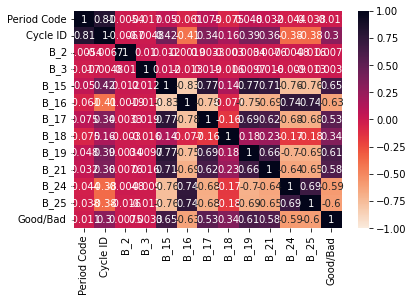

In [34]:
sns.heatmap(data.corr(), vmin=-1, vmax=1,
annot=True,cmap="rocket_r")

In [35]:
# Extract the sensor columns for PCA (excluding non-numeric and label columns)
sensor_columns = [col for col in data.columns if col.startswith('B_')]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[sensor_columns])

# Create a PCA instance with the number of components you desire
n_components = 5  # You can choose the number of principal components you want
pca = PCA(n_components=n_components)

# Fit and transform the standardized data
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame to store the principal components
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])

# Concatenate the PCA results with the original data (if needed)
result_df = pd.concat([data[['Cycle ID', 'timestamp', 'Good/Bad']], pca_df], axis=1)

# Print the explained variance ratio to understand the contribution of each PC
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratios:", explained_variance_ratio)

# You can also find the cumulative explained variance to determine the number of PCs to keep
cumulative_explained_variance = explained_variance_ratio.cumsum()
print("Cumulative Explained Variance:", cumulative_explained_variance)


Explained Variance Ratios: [0.53231733 0.11207627 0.10081758 0.09886421 0.03680467]
Cumulative Explained Variance: [0.53231733 0.6443936  0.74521118 0.84407539 0.88088006]


In [36]:
pca_df

,PC1,PC2,PC3,PC4,PC5
0,-2.132478,0.123186,-1.120862,-0.833404,-0.153256
1,-1.967529,-0.440371,-0.048571,-1.395281,-0.097471
2,-2.793413,-0.543071,-0.907617,2.007772,1.225506
3,-2.979895,-0.477971,0.214934,-0.245225,-0.200131
4,-1.905801,-0.072210,-1.120459,0.036636,-0.515204
...,...,...,...,...,...
16188,-1.283409,0.812345,0.507309,0.652777,0.383268
16189,-2.745702,0.625724,1.113888,0.133907,0.055969
16190,-2.378211,1.444369,-0.920308,-1.182408,0.846947
16191,-3.268088,0.649907,-0.314759,-0.482096,0.439546
